jupyter/ipython 覆盖了 sys.displayhook 方便他们在每次输出前打印`Output[1]`这样的 prompt 

相关的源码在 IPython/core/displayhook.py

In [3]:
# https://wwj718.github.io/post/%E6%9E%B6%E6%9E%84/jupyter-notebook-architecture/#kernel%E4%B8%AD%E7%9A%84socket%E5%AF%B9%E8%B1%A1
# https://jupyter-client.readthedocs.io/en/stable/messaging.html
import sys
print(f"sys.stdout = {sys.stdout}")
print(f"sys.stdout = {sys.stderr}")
print(f"sys.stdout.pub_thread = {sys.stdout.pub_thread}")

sys.stdout = <ipykernel.iostream.OutStream object at 0x7f7947d9e0b0>
sys.stdout = <ipykernel.iostream.OutStream object at 0x7f7947d9e170>
sys.stdout.pub_thread = <ipykernel.iostream.IOPubThread object at 0x7f7947d9f1c0>


在 zmq 中, ROUTER 是异步的 REP; DEALER 是异步的 REQ

|channel|client|server|作用|
|---|---|---|---|
|shell|DEALER|ROUTER|执行代码，获取代码执行结果(有点像主线程)|
|control|DEALER|ROUTER|由于 shell/stdin 都是 blocking 的，额外需要信道收发停止/重启 kernel|
|iopub|SUB|PUB|广播输出，且将代码执行结果 异步? 持久化到 ipynb 文件中|
|stdin|DEALER|ROUTER|input() 函数输入|
|hb|REQ|REP|心跳 kernel client 检查 kernel 是否 OOM 之类的|

control 从 shell 中单独开一个信道是为了避免停止 kernel 这种紧迫的控制命令被 shell socket 的消息队列阻塞，
例如一个 shell 的消息执行很久如果 stop 也在 shell 信道中就无法及时 stop

### iopub 补充说明

根据 jupyter_client 文档 docs/messageing.rst 的介绍，iopub 适用于多人同时编辑同一个页面，
例如用户 A 和 B 同时编辑 a.ipynb 那么就需要通过 iopub 订阅 a.ipynb 的改动，如果用户 A 改了用户 B 就能收到通知刷新内容，

就有点像聊天室应用，虽然所有聊天消息都共用一个 iopub 信道，但是非用户订阅的 ipynb 文件改动就不会收到推送

### zmq SocketType reference
- jupyter message: <https://jupyter-client.readthedocs.io/en/stable/messaging.html>
- client reference: <https://github.com/jupyter/jupyter_client/blob/0eb492726cc279fdb3e2ff690cb62e8a69182d0d/jupyter_client/connect.py#L313>
- server reference: <https://github.com/google/evcxr/blob/100f4320a5b12f470361188c703c870a19e975f3/evcxr_jupyter/src/control_file.rs#L24>

## kernel connection 例子

```json
{
  "shell_port": 44051,
  "iopub_port": 36085,
  "stdin_port": 46571,
  "control_port": 41759,
  "hb_port": 35003,
  "ip": "127.0.0.1",
  "key": "",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}
```

注意 json 的每一个配置项都有对应的命令行参数，用命令行参数也行

In [9]:
import gc
for obj in gc.get_objects():
    if type(obj).__name__ == "IPKernelApp":
        kernel = obj
        break
kernel.shell_socket, kernel.iopub_socket

(<zmq.Socket(zmq.ROUTER) at 0x7f7947d8a740>,
 <ipykernel.iostream.BackgroundSocket at 0x7f7947d9f220>)

In [16]:
kernel.shell.run_code("1")

<coroutine object InteractiveShell.run_code at 0x7f792dbefae0>

```python
    async def run_code(self, code_obj, result=None, *, async_=False):
        """Execute a code object.

        When an exception occurs, self.showtraceback() is called to display a
        traceback.

        Parameters
        ----------
        code_obj : code object
          A compiled code object, to be executed
        result : ExecutionResult, optional
          An object to store exceptions that occur during execution.
        async_ :  Bool (Experimental)
          Attempt to run top-level asynchronous code in a default loop.

        Returns
        -------
        False : successful execution.
        True : an error occurred.
        """
```

In [17]:
await kernel.shell.run_code("")

False

In [18]:
# module and namespace in which user code will be run.
# When IPython is started normally, both parameters are None
print(globals() is kernel.kernel.shell.user_global_ns)
print(globals() is kernel.kernel.shell.user_ns)

True
True


In [10]:
import threading
threading.enumerate()
# ParentPollerUnix 线程，监视父进程，如果父进程退出，则保证 Kernel 进程也退出

[<_MainThread(MainThread, started 140158927955776)>,
 <Thread(IOPub, started daemon 140158856017600)>,
 <Heartbeat(Heartbeat, started daemon 140158846576320)>,
 <Thread(Thread-2 (_watch_pipe_fd), started daemon 140158821398208)>,
 <Thread(Thread-3 (_watch_pipe_fd), started daemon 140158473074368)>,
 <ControlThread(Control, started daemon 140158464681664)>,
 <HistorySavingThread(IPythonHistorySavingThread, started 140158456288960)>,
 <GarbageCollectorThread(Thread-4, started daemon 140158432499392)>]

In [11]:
import traceback
traceback.print_stack()

  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/w/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/w/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/home/w/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start
    self.io_loop.start()
  File "/home/w/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
    handle._run()
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._contex

In [19]:
import inspect
frames = {}
for info in inspect.stack():
    if info[3] == "dispatch_shell":
        frames["request"] = info[0]
    if info[3] == "execute_request":
        frames["reply"] = info[0]
print(1)

1


In [20]:
frames["request"].f_locals["msg"]

{'header': {'date': datetime.datetime(2022, 12, 27, 11, 47, 39, 115000, tzinfo=tzutc()),
  'msg_id': '2164fc5e-cb8d-4f8e-88a3-995496e88f91',
  'msg_type': 'execute_request',
  'session': '10cdb17d-442f-4197-99b3-3960b342aad6',
  'username': '19ee6c97-f6ac-4d0a-ada9-6caa2342e75d',
  'version': '5.2'},
 'msg_id': '2164fc5e-cb8d-4f8e-88a3-995496e88f91',
 'msg_type': 'execute_request',
 'parent_header': {},
 'metadata': {'cellId': 'vscode-notebook-cell:/home/w/repos/baihai/IDP/mpl.ipynb#X16sZmlsZQ%3D%3D'},
 'content': {'silent': False,
  'store_history': True,
  'user_expressions': {},
  'allow_stdin': True,
  'stop_on_error': False,
  'code': 'import inspect\nframes = {}\nfor info in inspect.stack():\n    if info[3] == "dispatch_shell":\n        frames["request"] = info[0]\n    if info[3] == "execute_request":\n        frames["reply"] = info[0]\nprint(1)'},
 'buffers': []}

In [21]:
frames["reply"].f_locals["reply_msg"]

{'header': {'msg_id': '649e1c2f-1d0da991fe6c7c46c2c2aabc_281082_309',
  'msg_type': 'execute_reply',
  'username': 'w',
  'session': '649e1c2f-1d0da991fe6c7c46c2c2aabc',
  'date': datetime.datetime(2022, 12, 27, 11, 47, 39, 122510, tzinfo=datetime.timezone.utc),
  'version': '5.3'},
 'msg_id': '649e1c2f-1d0da991fe6c7c46c2c2aabc_281082_309',
 'msg_type': 'execute_reply',
 'parent_header': {'date': datetime.datetime(2022, 12, 27, 11, 47, 39, 115000, tzinfo=tzutc()),
  'msg_id': '2164fc5e-cb8d-4f8e-88a3-995496e88f91',
  'msg_type': 'execute_request',
  'session': '10cdb17d-442f-4197-99b3-3960b342aad6',
  'username': '19ee6c97-f6ac-4d0a-ada9-6caa2342e75d',
  'version': '5.2'},
 'content': {'status': 'ok',
  'execution_count': 19,
  'user_expressions': {},
  'payload': []},
 'metadata': {'started': datetime.datetime(2022, 12, 27, 11, 47, 39, 116939, tzinfo=datetime.timezone.utc),
  'dependencies_met': True,
  'engine': '08d11958-ad78-4af7-bdd9-99e1911035c7',
  'status': 'ok'},
 'tracker': <

---
## get_ipython() and magic command

In [12]:
from IPython import get_ipython
get_ipython()

In [13]:
import IPython
tm = IPython.core.inputtransformer2.TransformerManager()
code = '''!pwd
%pylab inline
'''
tm.transform_cell(code)

"get_ipython().system('pwd')\nget_ipython().run_line_magic('pylab', 'inline')\n"

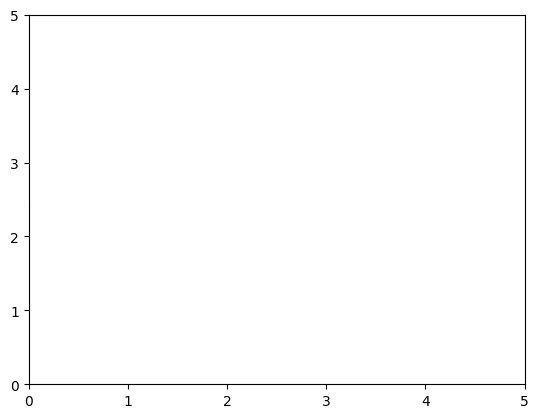

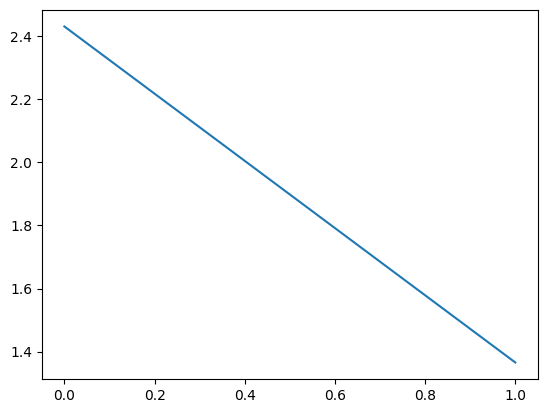

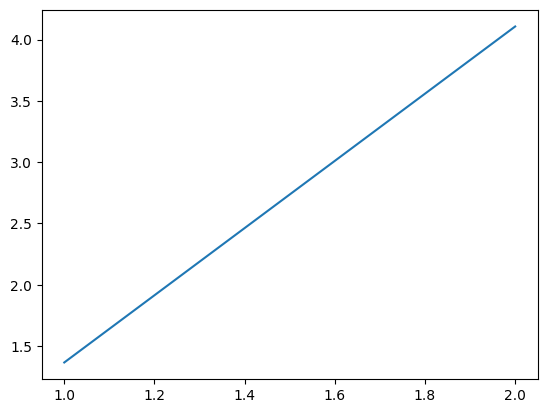

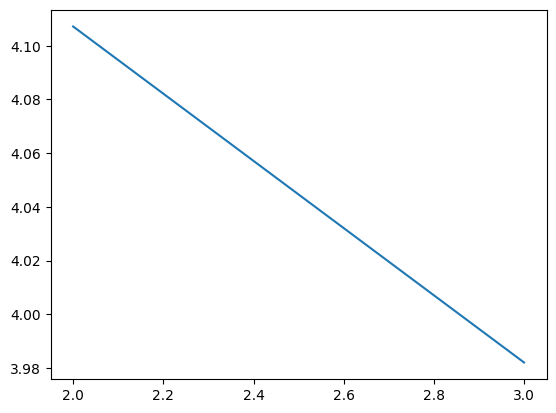

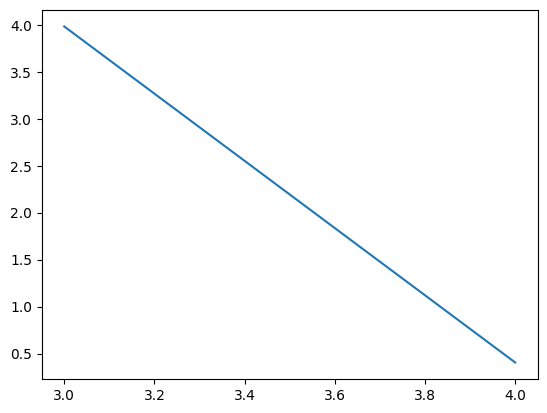

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import inspect
frames = {}
for info in inspect.stack():
    frames[info[3]] = info[0]

import sys
sys.displayhook = None

i = 5
j = 5
plt.axis([0, i, 0, j])
plt.ion()

xs = [0, 0]
ys = [1, 1]

for i in range(i):
    y = np.random.random() * j
    xs[0] = xs[1]
    ys[0] = ys[1]
    xs[1] = i
    ys[1] = y
    plt.plot(xs, ys)
    plt.pause(0.1)


In [28]:
print(len(frames))

20


In [30]:
import pprint
pprint.pprint(frames)

{'<cell line: 6>': <frame at 0x55e6b2f6da30, file '/tmp/ipykernel_281082/3474975994.py', line 6, code <cell line: 6>>,
 '<module>': <frame at 0x7f794ae76c00, file '/home/w/.local/lib/python3.10/site-packages/ipykernel_launcher.py', line 17, code <module>>,
 '_pseudo_sync_runner': <frame at 0x7f79464867a0, file '/home/w/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py', line 80, code _pseudo_sync_runner>,
 '_run': <frame at 0x7f794818f840, file '/usr/lib/python3.10/asyncio/events.py', line 95, code _run>,
 '_run_cell': <frame at 0x55e6b23d1d50, file '/home/w/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py', line 3030, code _run_cell>,
 '_run_code': <frame at 0x55e6b186f350, file '/usr/lib/python3.10/runpy.py', line 86, code _run_code>,
 '_run_module_as_main': <frame at 0x7f794ae11c40, file '/usr/lib/python3.10/runpy.py', line 196, code _run_module_as_main>,
 '_run_once': <frame at 0x55e6b23ac740, file '/usr/lib/python3.10/asyncio/base_events.py', li